In [9]:
import matplotlib
import json
import numpy as np
import pandas as pd
import datetime
import time
import math
import matplotlib.pyplot as plt
import copy
from IPython.display import clear_output
from scipy.special import boxcox1p, inv_boxcox
from scipy.stats import boxcox_normmax
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import matplotlib
from matplotlib.font_manager import FontProperties

matplotlib.rcParams['font.sans-serif']='Times New Roman' 
matplotlib.rcParams['font.size'] =20 
matplotlib.rcParams['mathtext.fontset'] ='stix' 
matplotlib.rcParams['axes.unicode_minus'] = False 


def evaluation_indicators(true_data,predict_data):
    true_data=np.array(true_data).reshape(-1,)
    predict_data=np.array(predict_data).reshape(-1,)
    
    mean_true_data=sum(true_data)/len(true_data)
    error=np.array(true_data)-np.array(predict_data)
    squareerror=error*error
    abserror=abs(error)
    relativeerror=abserror/true_data
    MSE=sum(squareerror)/len(squareerror)
    RMSE=MSE**(1/2)
    MAE=sum(abserror)/len(abserror)
    ARE=sum(relativeerror)/len(relativeerror)
    NSE=1-sum(squareerror)/sum((true_data-mean_true_data)**2)
    

    times=sum(relativeerror<0.2)
    
    true_data=np.array(true_data)
    predict_data=np.array(predict_data)
    Ex=true_data.mean()
    Ey=predict_data.mean()
    Exy=(true_data*predict_data).mean()
    Dx=(true_data*true_data).mean()-Ex*Ex
    Dy=(predict_data*predict_data).mean()-Ey*Ey
    r=(Exy-Ex*Ey)/((Dx*Dy)**(1/2))
    
    R2=1-MSE/(sum((true_data-mean_true_data)**2)/len(true_data))
    
    return [round(MSE,4),round(RMSE,4),round(MAE,4),round(ARE,4),\
            round(NSE,4),round(times/len(true_data),4),round(r,4),round(R2,4)]


import hydro_utils
from xarray.core.dataarray import DataArray

def evaluation_indicators(true_data, predict_data):
    true_data = DataArray(true_data)
    predict_data = DataArray(predict_data)
    
    metrics_name = hydro_utils.metrics.get_available_metrics()
    temp = hydro_utils.metrics.calculate_all_metrics(true_data,predict_data)
    result = [temp[i] for i in metrics_name]
    
    return result


from sklearn.metrics import precision_score, recall_score, f1_score
def evaluation_indicators_classification(true_lable, prediction):
    true_lable = np.array(true_lable).reshape(-1,)
    prediction = np.array(prediction).reshape(-1,)
    
    result = []
    #----------------------------- precision-----------------------------
    result.extend(precision_score(true_lable, prediction, average=None))
    result.append(precision_score(true_lable, prediction, average='micro'))
    result.append(precision_score(true_lable, prediction, average='macro'))
    result.append(precision_score(true_lable, prediction, average='weighted'))

    #----------------------------- recall-----------------------------
    result.extend(recall_score(true_lable, prediction, average=None))
    result.append(recall_score(true_lable, prediction, average='micro'))
    result.append(recall_score(true_lable, prediction, average='macro'))
    result.append(recall_score(true_lable, prediction, average='weighted'))

    #----------------------------- F1-value-----------------------------
    result.extend(f1_score(true_lable, prediction, average=None))
    result.append(f1_score(true_lable, prediction, average='micro'))
    result.append(f1_score(true_lable, prediction, average='macro'))
    result.append(f1_score(true_lable, prediction, average='weighted'))
    
    return result

In [3]:
trainStartDate = '1982-01-01'
trainEndDate = '2013-12-31'
testStartDate = '2014-01-1'
testEndDate = '2018-12-31'
trainDayLength = int((pd.to_datetime(trainEndDate)-pd.to_datetime(trainStartDate))/pd.Timedelta(1, 'day'))+1

##############################################################
with open(r'F:\jupyter_notebook\usa\result\stationID.txt', 'r') as f:
    all_stationID = f.readlines()

In [27]:
RF_randomSeed = np.ones(len(all_stationID))+10

for ID_i in range(0,len(all_stationID)):
    print(ID_i)
    stationID = all_stationID[ID_i][:-1]

    allData = pd.read_json(r'F:\jupyter_notebook\usa\data\%s.json'%(stationID))
    allData.index = pd.date_range(trainStartDate,testEndDate, freq='1D')

    allData = allData[[0,1,9,10]]

    trainData = allData[trainStartDate:trainEndDate].copy()
    testData = allData[testStartDate:testEndDate].copy()

    lag = 10
    ahead = 1

    xtrain = []
    ytrain = []
    for i in range(len(trainData)-lag-(ahead-1)):
        xtrain.append(trainData.iloc[i:i+lag,:].values)
        ytrain.append(trainData.iloc[i+lag+(ahead-1),0])
    xtrain = np.array(xtrain, dtype=np.float32)   
    ytrain = np.array(ytrain, dtype=np.float32).reshape(-1, 1)
   
    xtest = []
    ytest = []
    for i in range(len(testData)-lag-(ahead-1)):
        xtest.append(testData.iloc[i:i+lag,:].values)
        ytest.append(testData.iloc[i+lag+(ahead-1),0])
    xtest = np.array(xtest, dtype=np.float32)   
    ytest = np.array(ytest, dtype=np.float32).reshape(-1, 1)
    
    
    bounds = [0,pd.Series(ytrain.reshape(-1,)).quantile(0.3),pd.Series(ytrain.reshape(-1,)).quantile(0.9)]
    ytrainSL = np.array(bounds).reshape(1,-1).repeat(len(ytrain),0)
    ytrainSL = (ytrainSL<=ytrain).sum(1)
    ytestSL = np.array(bounds).reshape(1,-1).repeat(len(ytest),0)
    ytestSL = (ytestSL<=ytest).sum(1)
    
    
    print('RF')
    model_SL = RandomForestClassifier(random_state=11)
    model_SL.fit(xtrain.reshape(len(xtrain),-1), ytrainSL)  
    ytestSL_ = model_SL.predict(xtest.reshape(len(xtest),-1))
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\RF_SL_0.3_0.9\%s.json'%(stationID), 'w') as f:
        json.dump(ytestSL_.tolist(),f)
    
#     print('MLP')
#     model_SL = MLPClassifier(hidden_layer_sizes=(200,200),max_iter=10000, random_state=11)  
#     model_SL.fit(xtrain.reshape(len(xtrain),-1), ytrainSL)  
#     ytestSL_ = model_SL.predict(xtest.reshape(len(xtest),-1))
#     with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\MLP_SL_0.3_0.9\%s.json'%(stationID), 'w') as f:
#         json.dump(ytestSL_.tolist(),f)
    
#     print('SVM')
#     model_SL = SVC(random_state=11)   
#     model_SL.fit(xtrain.reshape(len(xtrain),-1), ytrainSL)  
#     ytestSL_ = model_SL.predict(xtest.reshape(len(xtest),-1))
#     with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\SVM_SL_0.3_0.9\%s.json'%(stationID), 'w') as f:
#         json.dump(ytestSL_.tolist(),f)
        
#     print('LR')
#     model_SL = LogisticRegression(random_state=11)
#     model_SL.fit(xtrain.reshape(len(xtrain),-1), ytrainSL)  
#     ytestSL_ = model_SL.predict(xtest.reshape(len(xtest),-1))
#     with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\LR_SL_0.3_0.9\%s.json'%(stationID), 'w') as f:
#         json.dump(ytestSL_.tolist(),f)
        
#     print('KNN')
#     model_SL = KNeighborsClassifier(p=2,metric="minkowski")
#     model_SL.fit(xtrain.reshape(len(xtrain),-1), ytrainSL)  
#     ytestSL_ = model_SL.predict(xtest.reshape(len(xtest),-1))
#     with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\KNN_SL_0.3_0.9\%s.json'%(stationID), 'w') as f:
#         json.dump(ytestSL_.tolist(),f)
    
    clear_output(wait=True)
    
    
with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\RF_SL_0.3_0.9\_RF_randomSeed.json', 'w') as f:
    json.dump(RF_randomSeed.reshape(-1,).tolist(),f)
# with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\MLP_SL_0.3_0.9\_MLP_randomSeed.json', 'w') as f:
#     json.dump(RF_randomSeed.reshape(-1,).tolist(),f)
# with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\SVM_SL_0.3_0.9\_SVM_randomSeed.json', 'w') as f:
#     json.dump(RF_randomSeed.reshape(-1,).tolist(),f)
# with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\LR_SL_0.3_0.9\_LR_randomSeed.json', 'w') as f:
#     json.dump(RF_randomSeed.reshape(-1,).tolist(),f)
# with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\KNN_SL_0.3_0.9\_KNN_randomSeed.json', 'w') as f:
#     json.dump(RF_randomSeed.reshape(-1,).tolist(),f)

273
SVM


In [55]:
RF_randomSeed = np.ones(len(all_stationID))+10

for ID_i in range(0,len(all_stationID)):
    print(ID_i)
    stationID = all_stationID[ID_i][:-1]

    allData = pd.read_json(r'F:\jupyter_notebook\usa\data\%s.json'%(stationID))
    allData.index = pd.date_range(trainStartDate,testEndDate, freq='1D')

    allData = allData[[0,1,9,10]]

    trainData = allData[trainStartDate:trainEndDate].copy()
    testData = allData[testStartDate:testEndDate].copy()

    lag = 10
    ahead = 1

    ytrain = []
    for i in range(len(trainData)-lag-(ahead-1)):
        ytrain.append(trainData.iloc[i+lag+(ahead-1),0])
    ytrain = np.array(ytrain, dtype=np.float32).reshape(-1, 1)
    
    train_size = int(0.9*len(ytrain))
    ytrain, yval = ytrain[:train_size], ytrain[train_size:]
   
    ytest = []
    for i in range(len(testData)-lag-(ahead-1)):
        ytest.append(testData.iloc[i+lag+(ahead-1),0])  
    ytest = np.array(ytest, dtype=np.float32).reshape(-1, 1)
    
    
    bounds = [0,pd.Series(ytrain.reshape(-1,)).quantile(0.5),pd.Series(ytrain.reshape(-1,)).quantile(0.9)]
    ytrainSL = np.array(bounds).reshape(1,-1).repeat(len(ytrain),0)
    ytrainSL = (ytrainSL<=ytrain).sum(1)
    ytestSL = np.array(bounds).reshape(1,-1).repeat(len(ytest),0)
    ytestSL = (ytestSL<=ytest).sum(1)
    
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_mre2Loss\training_set\%s.json'%(stationID), 'r') as f:
        ytrain_mapel_ = np.array(json.load(f))
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_highLevelBalance\training_set\%s.json'%(stationID), 'r') as f:
        ytrain_hfbl_ = np.array(json.load(f))
    with open(r'F:\jupyter_notebook\models_dl\result\lstm\training_set\%s.json'%(stationID), 'r') as f:
        ytrain_mse_ = np.array(json.load(f))
    xtrain = np.array([ytrain_mapel_, ytrain_hfbl_, ytrain_mse_]).T
    
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_mre2Loss\%s.json'%(stationID), 'r') as f:
        ytest_mapel_ = np.array(json.load(f))
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_highLevelBalance\%s.json'%(stationID), 'r') as f:
        ytest_hfbl_ = np.array(json.load(f))
    with open(r'F:\jupyter_notebook\models_dl\result\lstm\%s.json'%(stationID), 'r') as f:
        ytest_mse_ = np.array(json.load(f))
    xtest = np.array([ytest_mapel_, ytest_hfbl_, ytest_mse_]).T
    
    
    print('RF')
    model_SL = RandomForestClassifier(random_state=11)
    model_SL.fit(xtrain.reshape(len(xtrain),-1), ytrainSL)  
    ytestSL_ = model_SL.predict(xtest.reshape(len(xtest),-1))
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\2_RF_SL_0.5_0.9\%s.json'%(stationID), 'w') as f:
        json.dump(ytestSL_.tolist(),f)
    
#     print('MLP')
#     model_SL = MLPClassifier(hidden_layer_sizes=(200,200),max_iter=10000, random_state=11)  
#     model_SL.fit(xtrain.reshape(len(xtrain),-1), ytrainSL)  
#     ytestSL_ = model_SL.predict(xtest.reshape(len(xtest),-1))
#     with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\MLP_SL_0.3_0.9\%s.json'%(stationID), 'w') as f:
#         json.dump(ytestSL_.tolist(),f)
    
#     print('SVM')
#     model_SL = SVC(random_state=11)   
#     model_SL.fit(xtrain.reshape(len(xtrain),-1), ytrainSL)  
#     ytestSL_ = model_SL.predict(xtest.reshape(len(xtest),-1))
#     with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\SVM_SL_0.3_0.9\%s.json'%(stationID), 'w') as f:
#         json.dump(ytestSL_.tolist(),f)
        
#     print('LR')
#     model_SL = LogisticRegression(random_state=11)
#     model_SL.fit(xtrain.reshape(len(xtrain),-1), ytrainSL)  
#     ytestSL_ = model_SL.predict(xtest.reshape(len(xtest),-1))
#     with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\LR_SL_0.3_0.9\%s.json'%(stationID), 'w') as f:
#         json.dump(ytestSL_.tolist(),f)
        
#     print('KNN')
#     model_SL = KNeighborsClassifier(p=2,metric="minkowski")
#     model_SL.fit(xtrain.reshape(len(xtrain),-1), ytrainSL)  
#     ytestSL_ = model_SL.predict(xtest.reshape(len(xtest),-1))
#     with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\KNN_SL_0.3_0.9\%s.json'%(stationID), 'w') as f:
#         json.dump(ytestSL_.tolist(),f)
    
    clear_output(wait=True)
    
    
with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\2_RF_SL_0.5_0.9\_RF_randomSeed.json', 'w') as f:
    json.dump(RF_randomSeed.reshape(-1,).tolist(),f)
# with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\MLP_SL_0.3_0.9\_MLP_randomSeed.json', 'w') as f:
#     json.dump(RF_randomSeed.reshape(-1,).tolist(),f)
# with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\SVM_SL_0.3_0.9\_SVM_randomSeed.json', 'w') as f:
#     json.dump(RF_randomSeed.reshape(-1,).tolist(),f)
# with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\LR_SL_0.3_0.9\_LR_randomSeed.json', 'w') as f:
#     json.dump(RF_randomSeed.reshape(-1,).tolist(),f)
# with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\KNN_SL_0.3_0.9\_KNN_randomSeed.json', 'w') as f:
#     json.dump(RF_randomSeed.reshape(-1,).tolist(),f)

273
RF


In [10]:
RF_randomSeed = np.ones(len(all_stationID))+10

for ID_i in range(0,len(all_stationID)):
    print(ID_i)
    stationID = all_stationID[ID_i][:-1]

    allData = pd.read_json(r'F:\jupyter_notebook\usa\data\%s.json'%(stationID))
    allData.index = pd.date_range(trainStartDate,testEndDate, freq='1D')

    allData = allData[[0,1,9,10]]

    trainData = allData[trainStartDate:trainEndDate].copy()
    testData = allData[testStartDate:testEndDate].copy()

    lag = 10
    ahead = 1

    ytrain = []
    for i in range(len(trainData)-lag-(ahead-1)):
        ytrain.append(trainData.iloc[i+lag+(ahead-1),0])
    ytrain = np.array(ytrain, dtype=np.float32).reshape(-1)
    
    train_size = int(0.9*len(ytrain))
    ytrain, yval = ytrain[:train_size], ytrain[train_size:]
   
    ytest = []
    for i in range(len(testData)-lag-(ahead-1)):
        ytest.append(testData.iloc[i+lag+(ahead-1),0])  
    ytest = np.array(ytest, dtype=np.float32).reshape(-1)
    
    
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_mre2Loss\training_set\%s.json'%(stationID), 'r') as f:
        ytrain_mapel_ = np.array(json.load(f))
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_highLevelBalance\training_set\%s.json'%(stationID), 'r') as f:
        ytrain_hfbl_ = np.array(json.load(f))
    with open(r'F:\jupyter_notebook\models_dl\result\lstm\training_set\%s.json'%(stationID), 'r') as f:
        ytrain_mse_ = np.array(json.load(f))
    xtrain = np.array([ytrain_mapel_, ytrain_hfbl_, ytrain_mse_]).T
    
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_mre2Loss\%s.json'%(stationID), 'r') as f:
        ytest_mapel_ = np.array(json.load(f))
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_highLevelBalance\%s.json'%(stationID), 'r') as f:
        ytest_hfbl_ = np.array(json.load(f))
    with open(r'F:\jupyter_notebook\models_dl\result\lstm\%s.json'%(stationID), 'r') as f:
        ytest_mse_ = np.array(json.load(f))
    xtest = np.array([ytest_mapel_, ytest_hfbl_, ytest_mse_]).T
    
    
    print('RF')
    model_SL = RandomForestRegressor(random_state=11)
    model_SL.fit(xtrain.reshape(len(xtrain),-1), ytrain)  
    ytest_ = model_SL.predict(xtest.reshape(len(xtest),-1))
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel3\stacking_RF_0.5_0.9\%s.json'%(stationID), 'w') as f:
        json.dump(ytest_.tolist(),f)
    
#     print('MLP')
#     model_SL = MLPClassifier(hidden_layer_sizes=(200,200),max_iter=10000, random_state=11)  
#     model_SL.fit(xtrain.reshape(len(xtrain),-1), ytrain)  
#     ytest_ = model_SL.predict(xtest.reshape(len(xtest),-1))
#     with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel3\MLP_SL_0.3_0.9\%s.json'%(stationID), 'w') as f:
#         json.dump(ytest_.tolist(),f)
    
#     print('SVM')
#     model_SL = SVC(random_state=11)   
#     model_SL.fit(xtrain.reshape(len(xtrain),-1), ytrain)  
#     ytest_ = model_SL.predict(xtest.reshape(len(xtest),-1))
#     with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel3\SVM_SL_0.3_0.9\%s.json'%(stationID), 'w') as f:
#         json.dump(ytest_.tolist(),f)
        
#     print('LR')
#     model_SL = LogisticRegression(random_state=11)
#     model_SL.fit(xtrain.reshape(len(xtrain),-1), ytrain)  
#     ytest_ = model_SL.predict(xtest.reshape(len(xtest),-1))
#     with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel3\LR_SL_0.3_0.9\%s.json'%(stationID), 'w') as f:
#         json.dump(ytest_.tolist(),f)
        
#     print('KNN')
#     model_SL = KNeighborsClassifier(p=2,metric="minkowski")
#     model_SL.fit(xtrain.reshape(len(xtrain),-1), ytrain)  
#     ytest_ = model_SL.predict(xtest.reshape(len(xtest),-1))
#     with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel3\KNN_SL_0.3_0.9\%s.json'%(stationID), 'w') as f:
#         json.dump(ytest_.tolist(),f)
    
    clear_output(wait=True)
    
    
with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel3\stacking_RF_0.5_0.9\_RF_randomSeed.json', 'w') as f:
    json.dump(RF_randomSeed.reshape(-1,).tolist(),f)
# with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel3\MLP_SL_0.3_0.9\_MLP_randomSeed.json', 'w') as f:
#     json.dump(RF_randomSeed.reshape(-1,).tolist(),f)
# with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel3\SVM_SL_0.3_0.9\_SVM_randomSeed.json', 'w') as f:
#     json.dump(RF_randomSeed.reshape(-1,).tolist(),f)
# with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel3\LR_SL_0.3_0.9\_LR_randomSeed.json', 'w') as f:
#     json.dump(RF_randomSeed.reshape(-1,).tolist(),f)
# with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel3\KNN_SL_0.3_0.9\_KNN_randomSeed.json', 'w') as f:
#     json.dump(RF_randomSeed.reshape(-1,).tolist(),f)

273
RF


In [58]:
for ID_i in range(0,len(all_stationID)):
    print(ID_i)
    stationID = all_stationID[ID_i][:-1]
    
    allData = pd.read_json(r'F:\jupyter_notebook\usa\data\%s.json'%(stationID))
    allData.index = pd.date_range(trainStartDate,testEndDate, freq='1D')

    allData = allData[[0,1,9,10]]

    trainData = allData[trainStartDate:trainEndDate].copy()
    testData = allData[testStartDate:testEndDate].copy()

    lag = 10
    ahead = 1

    ytrain = []
    for i in range(len(trainData)-lag-(ahead-1)):
        ytrain.append(trainData.iloc[i+lag+(ahead-1),0])
    ytrain = np.array(ytrain, dtype=np.float32).reshape(-1, 1)
    
    bounds = [0,pd.Series(ytrain.reshape(-1,)).quantile(0.5),pd.Series(ytrain.reshape(-1,)).quantile(0.9)]

    with open(r'F:\jupyter_notebook\models_dl\result\lstm_highLevelBalance_mreloss2\%s.json'%(stationID), 'r') as f:
        ytest_ = np.array(json.load(f)).reshape(-1, 1)
    ytest_[ytest_<0] = 0
    ytestSL_lstm_ = np.array(bounds).reshape(1,-1).repeat(len(ytest_),0)
    ytestSL_lstm_ = (ytestSL_lstm_<=ytest_).sum(1)
    
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\LSTMmapehfb_SL_0.5_0.9\%s.json'%(stationID), 'w') as f:
        json.dump(ytestSL_lstm_.tolist(),f)
    
    clear_output(wait=True)
    

273


In [25]:
rf_indicators = []
for ID_i in range(len(all_stationID)):
    print(ID_i)
    stationID = all_stationID[ID_i][:-1]

    allData = pd.read_json(r'F:\jupyter_notebook\usa\data\%s.json'%(stationID))
    allData.index = pd.date_range(trainStartDate,testEndDate, freq='1D')

    allData = allData[[0,1,9,10]]

    trainData = allData[trainStartDate:trainEndDate].copy()
    testData = allData[testStartDate:testEndDate].copy()

    lag = 10
    ahead = 1

    xtrain = []
    ytrain = []
    for i in range(len(trainData)-lag-(ahead-1)):
        xtrain.append(trainData.iloc[i:i+lag,:].values)
        ytrain.append(trainData.iloc[i+lag+(ahead-1),0])
    xtrain = np.array(xtrain, dtype=np.float32)   
    ytrain = np.array(ytrain, dtype=np.float32).reshape(-1, 1)
   
    xtest = []
    ytest = []
    for i in range(len(testData)-lag-(ahead-1)):
        xtest.append(testData.iloc[i:i+lag,:].values)
        ytest.append(testData.iloc[i+lag+(ahead-1),0])
    xtest = np.array(xtest, dtype=np.float32)   
    ytest = np.array(ytest, dtype=np.float32).reshape(-1, 1)
    
    
    bounds = [0,pd.Series(ytrain.reshape(-1,)).quantile(0.5),pd.Series(ytrain.reshape(-1,)).quantile(0.9)]
    ytrainSL = np.array(bounds).reshape(1,-1).repeat(len(ytrain),0)
    ytrainSL = (ytrainSL<=ytrain).sum(1)
    ytestSL = np.array(bounds).reshape(1,-1).repeat(len(ytest),0)
    ytestSL = (ytestSL<=ytest).sum(1)

    with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\RF_SL_0.5_0.9\%s.json'%(stationID), 'r') as f:
        ytestSL_ = json.load(f)

    rf_indicators.append(evaluation_indicators_classification(ytestSL, ytestSL_))
    
    clear_output(wait=True)
    
rf_indicators = np.array(rf_indicators)

273


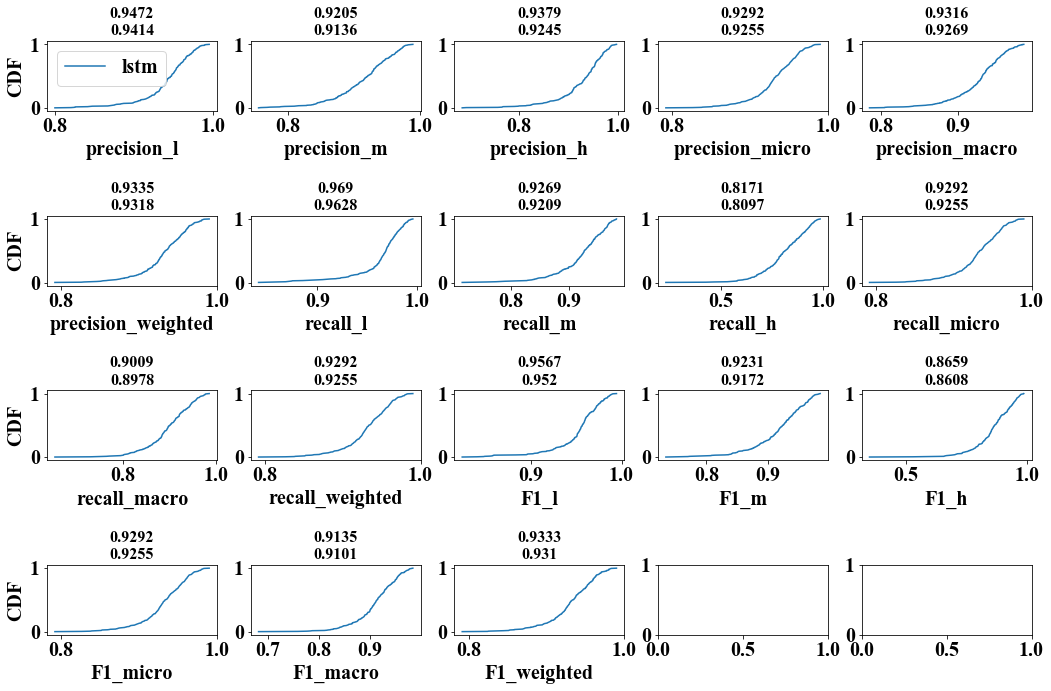

In [32]:
def CDF_plot(data):
    denominator=len(data)
    Data=pd.Series(data)
    Fre=Data.value_counts()
    Fre_sort=Fre.sort_index(axis=0,ascending=True)
    Fre_df=Fre_sort.reset_index()
    Fre_df[0]=Fre_df[0]/denominator
    Fre_df.columns=['Rds','Fre']
    Fre_df['cumsum']=np.cumsum(Fre_df['Fre'])
    return Fre_df

temp = ['precision_l', 'precision_m', 'precision_h', 'precision_micro', 'precision_macro', 'precision_weighted',
        'recall_l', 'recall_m', 'recall_h', 'recall_micro', 'recall_macro', 'recall_weighted', 
        'F1_l', 'F1_m', 'F1_h', 'F1_micro', 'F1_macro', 'F1_weighted']

fig, axs = plt.subplots(nrows=4, ncols=5,figsize=(15,10))
for i in range(18):

    Fre_df = CDF_plot(pd.Series(rf_indicators[:,i]))
    axs[(i)//5,(i)%5].plot(Fre_df['Rds'],Fre_df['cumsum'],label='lstm')
    median1 = round(Fre_df['Rds'].median(),4)
    mean1 = round(Fre_df['Rds'].mean(),4) 

    if i == 0:
        axs[(i)//5,(i)%5].legend()
    axs[(i)//5,(i)%5].set_xlabel(temp[i])
    if (i)%5 == 0:
        axs[(i)//5,(i)%5].set_ylabel("CDF")
        
#     axs[(i)//5,(i)%5].plot([1,1],[0,1])
    axs[(i)//5,(i)%5].set_title('%s\n%s'%(median1,mean1),fontsize=16)

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
# plt.tight_layout()
plt.show()

In [41]:
startDate = '2014-01-01'
endDate = '2018-12-31'
dayLength = int((pd.to_datetime(endDate)-pd.to_datetime(startDate))/pd.Timedelta(1, 'day'))+1

lstm_indicators_a = []
lstm_dl_indicators_a = []
lstm_indicators_l = []
lstm_dl_indicators_l = []
lstm_indicators_m = []
lstm_dl_indicators_m = []
lstm_indicators_h = []
lstm_dl_indicators_h = []
for ID_i in range(len(all_stationID)):
    clear_output(wait=True)
    print(ID_i)
    stationID = all_stationID[ID_i][:-1]
    
    allData = pd.read_json(r'F:\jupyter_notebook\usa\data\%s.json'%(stationID))
    
    low_flood = allData.iloc[:-dayLength,0].quantile(0.5)
    high_flood = allData.iloc[:-dayLength,0].quantile(0.9)
    
    ytest = allData[-dayLength:].iloc[10:,0].values
    
    with open(r'F:\jupyter_notebook\models_dl2\result\lstm\%s.json'%(stationID), 'r') as f:
        ytest_lstm = np.array(json.load(f))        
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_mre2Loss\%s.json'%(stationID), 'r') as f:
        ytest_l = np.array(json.load(f))        
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_highLevelBalance\%s.json'%(stationID), 'r') as f:
        ytest_h = np.array(json.load(f))
    with open(r'F:\jupyter_notebook\models_dl\result\lstm_differentFlowLevel2\RF_SL_0.5_0.9\%s.json'%(stationID), 'r') as f:
        ytestSL_ = np.array(json.load(f))
        
    ytest_ = ytest_lstm.copy()
    ytest_[ytestSL_==1] = ytest_l[ytestSL_==1]
    ytest_[ytestSL_==3] = ytest_h[ytestSL_==3]
    
    lstm_indicators_a.append(evaluation_indicators(ytest, ytest_lstm))
    lstm_dl_indicators_a.append(evaluation_indicators(ytest, ytest_))
    lstm_indicators_l.append(evaluation_indicators(ytest[ytest<low_flood], ytest_lstm[ytest<low_flood]))
    lstm_dl_indicators_l.append(evaluation_indicators(ytest[ytest<low_flood], ytest_[ytest<low_flood]))
    lstm_indicators_m.append(evaluation_indicators(ytest[(ytest>=low_flood)&(ytest<=high_flood)], 
                                                   ytest_lstm[(ytest>=low_flood)&(ytest<=high_flood)]))
    lstm_dl_indicators_m.append(evaluation_indicators(ytest[(ytest>=low_flood)&(ytest<=high_flood)], 
                                                      ytest_[(ytest>=low_flood)&(ytest<=high_flood)]))
    lstm_indicators_h.append(evaluation_indicators(ytest[ytest>high_flood],  ytest_lstm[ytest>high_flood]))
    lstm_dl_indicators_h.append(evaluation_indicators(ytest[ytest>high_flood], ytest_[ytest>high_flood]))
    
lstm_indicators_a = np.array(lstm_indicators_a)
lstm_dl_indicators_a = np.array(lstm_dl_indicators_a)
lstm_indicators_l = np.array(lstm_indicators_l)
lstm_dl_indicators_l = np.array(lstm_dl_indicators_l)
lstm_indicators_m = np.array(lstm_indicators_m)
lstm_dl_indicators_m = np.array(lstm_dl_indicators_m)
lstm_indicators_h = np.array(lstm_indicators_h)
lstm_dl_indicators_h = np.array(lstm_dl_indicators_h)

273


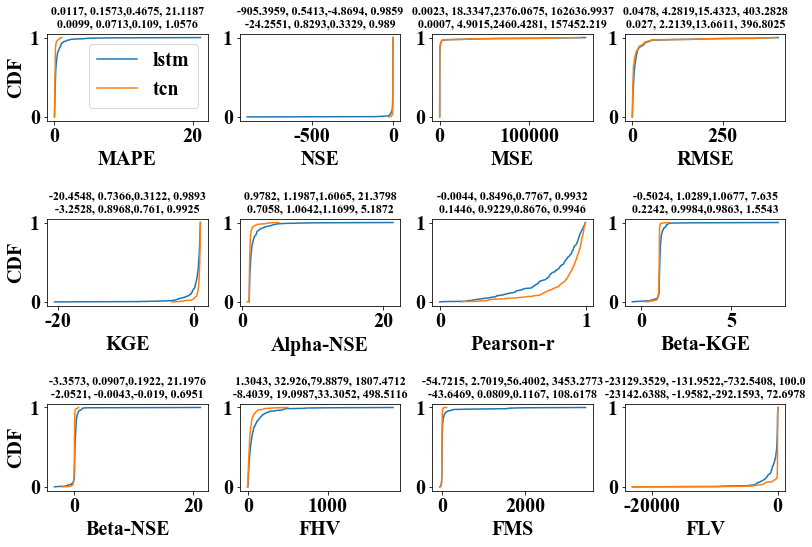

In [22]:
def CDF_plot(data):
    denominator=len(data)#分母数量
    Data=pd.Series(data)#将数据转换为Series利用分组频数计算
    Fre=Data.value_counts()
    Fre_sort=Fre.sort_index(axis=0,ascending=True)
    Fre_df=Fre_sort.reset_index()#将Series数据转换为DataFrame
    Fre_df[0]=Fre_df[0]/denominator#转换成概率
    Fre_df.columns=['Rds','Fre']
    Fre_df['cumsum']=np.cumsum(Fre_df['Fre'])
    return Fre_df

temp = ['MAPE', 'NSE', 'MSE', 'RMSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'FHV', 'FMS', 'FLV']

fig, axs = plt.subplots(nrows=3, ncols=4,figsize=(12,8))
for i in range(12):

    Fre_df = CDF_plot(pd.Series(lstm_indicators_l[:,i]))
    axs[(i)//4,(i)%4].plot(Fre_df['Rds'],Fre_df['cumsum'],label='lstm')
    min1 = round(Fre_df['Rds'].min(),4)
    median1 = round(Fre_df['Rds'].median(),4)
    mean1 = round(Fre_df['Rds'].mean(),4)
    max1 = round(Fre_df['Rds'].max(),4) 
    Fre_df = CDF_plot(pd.Series(lstm_dl_indicators_l[:,i]))
    axs[(i)//4,(i)%4].plot(Fre_df['Rds'],Fre_df['cumsum'],label='tcn')
    min2 = round(Fre_df['Rds'].min(),4)
    median2 = round(Fre_df['Rds'].median(),4)
    mean2 = round(Fre_df['Rds'].mean(),4)
    max2 = round(Fre_df['Rds'].max(),4)

    if i == 0:
        axs[(i)//4,(i)%4].legend()
    axs[(i)//4,(i)%4].set_xlabel(temp[i])
    if (i)%4 == 0:
        axs[(i)//4,(i)%4].set_ylabel("CDF")
        
#     axs[(i)//4,(i)%4].plot([1,1],[0,1])
    axs[(i)//4,(i)%4].set_title('%s, %s,%s, %s\n%s, %s,%s, %s'%(min1,median1,mean1,max1,min2,median2,mean2,max2),fontsize=12)

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
# plt.tight_layout()
plt.show()